In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scint

# Tutorial - Solving ODEs using scipy.integrate's RK45, DenseOutput and solve_ivp functionalities
### Author: Siddharth Mahesh

In this notebook, we will demonstrate, using a simple, well-behaved Hamiltonian, how we can integrate the Hamilton's equations of motion using scipy.integrate's ode-solving features. To begin we will specify the system of interest.

## The System of Interest:

For this demonstration, we will use the Hamiltonian for the 2-d Harmonic Oscillator:

$$
\mathcal{H} = \frac{px^2 + py^2}{2} + \frac{\omega_x^2 x^2 + \omega_y^2 y^2}{2} 
$$

The equations of motion for the above system can be rewritten as a general first-order ordinary differential equation as follows:

$$
\dot{\vec{\eta}} = \vec{f}(t,\vec{\eta})
$$

Where, $\vec{\eta} = (x,y,p_x,p_y)$ and the dot denotes a time derivative. The function $\vec{f}$ can be written as:

$$
\vec{f} = (p_x,p_y,-\omega_x^2 x, -\omega_y^2 y)
$$

We will therefore write two wrapper functions, one where the omegas can be passed as parameters and another where the wrapper function is generated using the omegas as input parameters instead. Let us first define the hamiltonian derivatives regardless of this choice

In [2]:
def Ham_derivs(x,y,px,py,omega2x,omega2y):
    return np.array([px,py,-omega2x*x,-omega2y*y])

## Case 1: Generate wrapper using $\omega$'s as input

In this case, we will create a wrapper function where $\omega_x,\omega_y$ are provided as inputs to generate the wrapper function.

In [3]:
def generate_wrapper_with_these_inputs(omega2x,omega2y):
    func = lambda t,eta: Ham_derivs(eta[0],eta[1],eta[2],eta[3],omega2x,omega2y)
    return func


## Case 2: Generate wrapper with $\omega$'s as keyword arguments

In this case, we will create a wrapper function using python's keyword arguments functionality. 

In [4]:
def wrapper_function(t,eta,**params):
    omega2x = params["omega2x"]
    omega2y = params["omega2y"]
    x, y, px, py = eta[0], eta[1], eta[2], eta[3]
    return Ham_derivs(x,y,px,py,omega2x,omega2y)

## Define the Initial Conditions and Final Conditions

For this demonstration, we will be using the initial conditions:

$$
x(0) = 1\\
y(0) = 0\\
p_x(0) = 0\\
p_y(0) = \omega_y
$$

Which should give the following solution for the trajectory of the particle (famously known as the Lissajous figure):

$$
\vec{r} = (x,y) = (\cos\omega_x t, \sin\omega_y t)
$$

We also define the stopping conditions as to stop if one of the positions: $x$  or $y > 1 + \epsilon$, i.e if the oscillator has moved past it's amplitude by some tolerance factor $\epsilon$ as well as if the momentum exceeds the maximum momentum i.e, $p_x > \omega_x(1 + \epsilon)$ or $p_y > \omega_y(1 + \epsilon)$. Finally we stop when we have made 20 orbits of the lowest frequency, i.e $t > \frac{40\pi}{\rm{min}(\omega_x,\omega_y)}$.

In [5]:
def generate_initial_conditions(omegax,omegay):
    return np.array([1,0,0,omegay])

def stop_conditions(t,eta,omegax,omegay,eps):
    factor = 1. + eps
    max_time = 40*np.pi/(min(omegax,omegay))
    if eta[0] > factor or eta[1] > factor:
        return -1
    if eta[2] > omegax*factor or eta[3] > omegay*factor:
        return -2
    if t > max_time:
        return 0
    return 1

## Create the RK45 object

We now create an RK45 object that will factor in all the initial conditions and the right hand side function so that the resulting object can be used to perform adaptive integration.

In [6]:
omega_x = 1.2
omega_y = 1.1

omega2_x = omega_x*omega_x
omega2_y = omega_y*omega_y

t_0 = 0
eta_0 = generate_initial_conditions(omega_x,omega_y)

generated_wrapper_function = generate_wrapper_with_these_inputs(omega2_x,omega2_y)

run_case_1 = scint.RK45(generated_wrapper_function,t_0,eta_0,200)
print(run_case_1.t)
#run_case_2 = scint.RK45(wrapper_function,t_0,eta_0,200,omega2x = omega2_x,omega2y = omega2_y)

0


In [7]:
## just testing the wrapper function

test_wrapper1_output = generated_wrapper_function(0.,[1.,0.,0.,omega_y])
test_wrapper2_output = wrapper_function(0.,[1.,0.,0.,omega_y],omega2x = omega2_x,omega2y = omega2_y)
print(test_wrapper1_output)
print(test_wrapper2_output)

[ 0.    1.1  -1.44 -0.  ]
[ 0.    1.1  -1.44 -0.  ]


## Performing The Routine and Generating the Trajectory

In this section, we run the integrator as well as generate output to plot the trajectory. In this case we will first store the output using the attributes of the RK45 objects which are `RK45.t` and `RK45.y`. However, since we are using adaptive timestepping, the points in the trajectory will not be uniformally or densely sampled. In order to get a densely sampled output between the previous timestep and the current one, we will create a DenseOutput object from the integrator object to which we will pass an array of points in time. The DenseOutput object will then return an array of interpolated values of the solution at those points.


0


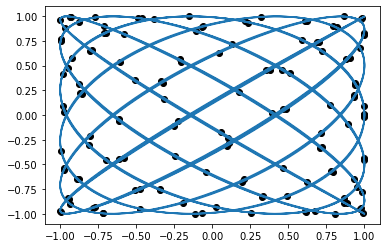

In [8]:
run = 1
eta_scatter = []
time_scatter = []
dt = 0.01

eta_plot = []
time_plot = []
while run == 1:
    #print(run_case_1.t)
    eta_scatter.append(run_case_1.y)
    time_scatter.append(run_case_1.t)
    run_case_1.step()
    dns_opt = run_case_1.dense_output()
    time_array = np.arange(time_scatter[-1],run_case_1.t,dt)
    vals_array = dns_opt.__call__(time_array)
    #print(time_array)
    #print(vals_array)
    for i in range(len(time_array)):
        time_plot.append(time_array[i])
        elt = vals_array[:,i]
        eta_plot.append(elt)
    run = stop_conditions(time_scatter[-1],eta_scatter[-1],omega_x,omega_y,1e-2)

print(run)

eta_scatter = np.array(eta_scatter)
eta_plot = np.array(eta_plot)

plt.scatter(eta_scatter[:,0],eta_scatter[:,1],color = 'black')
plt.plot(eta_plot[:,0],eta_plot[:,1])
plt.show()

## Dense and sparse outputs using `solve_ivp`

Finally, we look at an additional way to integrate ODEs that does not require us to manually propagate te integrator. This is scipy.integrate's `solve_ivp` function which takes in as arguments (relevant to this demo):

1. `fun` - The RHS function for the first order ODE
2. `t_span` -  a 2-element tuple that specifies a start and end time for the integration
3. `y0` - initial conditions
4. `method` - integration method such as RK45, etc
6. `dense_output` - in case a continuous solution is required
7. `events` - conditions to track. Allows for implementing stop conditions

We first must construct functions for the RHS and stop conditions to put into the events argument.

In [9]:
def RHS_func(t,eta,omega2x,omega2y):
    x, y, px, py = eta[0], eta[1], eta[2], eta[3]
    return Ham_derivs(x,y,px,py,omega2x,omega2y)

def stop_condition_x(t,eta,omegax,omegay):
    return eta[0] - 1

def stop_condition_y(t,eta,omegax,omegay):
    return eta[1] - 1

def stop_condition_px(t,eta,omegax,omegay):
    return eta[1] - omegax

def stop_condition_py(t,eta,omegax,omegay):
    return eta[2] - omegay

We now call the `solve_ivp` function for the original input parameters and initial conditions.

In [10]:
max_time = 40*np.pi/min(omega_x,omega_y)
result = scint.solve_ivp(RHS_func,(0,max_time),eta_0,method = 'RK45', dense_output = True, events = [stop_condition_x,stop_condition_y,stop_condition_px,stop_condition_py], args = (omega2_x,omega2_y))


We finally plot the result to get the Lissajous figure

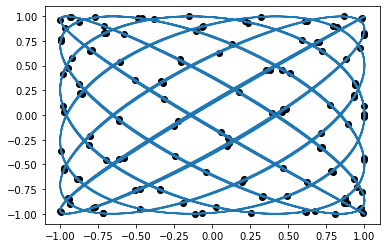

In [11]:
dt = 0.01
time_series = np.arange(0.,max_time,dt) 

sparse_array = result.y
dense_sol = result.sol.__call__(time_series)
plot_array = np.array([ dense_sol[:,i] for i in range(len(time_series))])

plt.scatter(sparse_array[0,:],sparse_array[1,:], color = 'black')
plt.plot(plot_array[:,0], plot_array[:,1])
plt.show()